<h2>Import Data and Required Packages

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import warnings

In [2]:
df = pd.read_csv('data/pyrolysis.csv')

In [3]:
df.head()

,Index,Biomass species,M,Ash,VM,FC,C,H,O,N,PS,FT,HR,FR,Solid phase,Liquid phase,Gas phase
0,1,Jerusalem artichoke stick,15.76,3.34,67.40,13.50,45.36,6.11,47.26,0.75,0.5,550,10.0,100.0,35,44.9,20.1
1,2,Jerusalem artichoke stick,15.76,3.34,67.40,13.50,45.36,6.11,47.26,0.75,0.5,650,10.0,100.0,31.75,41.25,27
2,3,Jerusalem artichoke stick,15.76,3.34,67.40,13.50,45.36,6.11,47.26,0.75,0.5,750,10.0,100.0,30.2,40.6,29.2
3,4,Jerusalem artichoke stick,15.76,3.34,67.40,13.50,45.36,6.11,47.26,0.75,0.5,850,10.0,100.0,28.6,36.36,35.04
4,5,reed,5.89,8.47,72.12,13.52,42.78,5.17,50.51,1.33,0.5,550,10.0,100.0,32.85,54.38,12.77


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Index            751 non-null    int64  
 1   Biomass species  751 non-null    object 
 2   M                632 non-null    float64
 3   Ash              733 non-null    float64
 4   VM               683 non-null    float64
 5   FC               683 non-null    float64
 6   C                748 non-null    float64
 7   H                748 non-null    float64
 8   O                748 non-null    float64
 9   N                721 non-null    float64
 10  PS               650 non-null    object 
 11  FT               751 non-null    int64  
 12  HR               641 non-null    float64
 13  FR               570 non-null    float64
 14  Solid phase      742 non-null    object 
 15  Liquid phase     715 non-null    object 
 16  Gas phase        715 non-null    object 
dtypes: float64(10), 

We can see that data type of PS feature is 'object'. Converting it to either int64 or float64

In [5]:
df["PS"] = pd.to_numeric(df["PS"], errors="coerce")
df["Liquid phase"] = pd.to_numeric(df["Liquid phase"], errors="coerce")

In [6]:
df.dtypes

Index                int64
Biomass species     object
M                  float64
Ash                float64
VM                 float64
FC                 float64
C                  float64
H                  float64
O                  float64
N                  float64
PS                 float64
FT                   int64
HR                 float64
FR                 float64
Solid phase         object
Liquid phase       float64
Gas phase           object
dtype: object

<h2> Handeling Missing Values

In [7]:
df.isna().sum()

Index                0
Biomass species      0
M                  119
Ash                 18
VM                  68
FC                  68
C                    3
H                    3
O                    3
N                   30
PS                 115
FT                   0
HR                 110
FR                 181
Solid phase          9
Liquid phase        39
Gas phase           36
dtype: int64

<h4> Using Simple Imputer to handle missing values


In [8]:
from sklearn.impute import SimpleImputer

# Identify numerical and categorical columns
num_features = df.select_dtypes(exclude="object").columns
cat_features = df.select_dtypes(include="object").columns

# Create Imputers
num_imputer = SimpleImputer(strategy="median")  # Median for numerical
cat_imputer = SimpleImputer(strategy="most_frequent")  # Most frequent for categorical

# Apply Imputers
df[num_features] = num_imputer.fit_transform(df[num_features])  # Transform numerical columns
df[cat_features] = cat_imputer.fit_transform(df[cat_features])  # Transform categorical columns

# Print to check if nulls are removed
print("Missing values after imputation:\n", df.isna().sum())

Missing values after imputation:
 Index              0
Biomass species    0
M                  0
Ash                0
VM                 0
FC                 0
C                  0
H                  0
O                  0
N                  0
PS                 0
FT                 0
HR                 0
FR                 0
Solid phase        0
Liquid phase       0
Gas phase          0
dtype: int64


All missing values handelled!

<h4> Checking for duplicates and dropping them

In [9]:
df.duplicated().sum()

0

No Duplicates!

<h2> Defining input and target features</h4>

All columns expect Solid phase, liquid phase, and gas phase are input featues.
I will be taking Biofuel i.e Liquid Phase as my target feature

In [10]:
X = df.drop(columns=['Index', 'Solid phase','Liquid phase', 'Gas phase','Index'],axis=1) 
y = df['Liquid phase'] #bio fuel

In [11]:
print("X = ", X.head())
print("y = ", y.head())

X =               Biomass species      M  Ash      VM     FC      C     H      O  \
0  Jerusalem artichoke stick  15.76  3.34  67.40  13.50  45.36  6.11  47.26   
1  Jerusalem artichoke stick  15.76  3.34  67.40  13.50  45.36  6.11  47.26   
2  Jerusalem artichoke stick  15.76  3.34  67.40  13.50  45.36  6.11  47.26   
3  Jerusalem artichoke stick  15.76  3.34  67.40  13.50  45.36  6.11  47.26   
4                       reed   5.89  8.47  72.12  13.52  42.78  5.17  50.51   

      N   PS     FT    HR     FR  
0  0.75  0.5  550.0  10.0  100.0  
1  0.75  0.5  650.0  10.0  100.0  
2  0.75  0.5  750.0  10.0  100.0  
3  0.75  0.5  850.0  10.0  100.0  
4  1.33  0.5  550.0  10.0  100.0  
y =  0    44.90
1    41.25
2    40.60
3    36.36
4    54.38
Name: Liquid phase, dtype: float64


<h2> Handeling categorical features


In [12]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA


# Identify numerical & categorical features
num_features = X.select_dtypes(exclude="object").columns.tolist()
cat_features = ["Biomass species"]  # Only categorical feature

# **Numerical Pipeline**
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Handle missing values
    ("scaler", StandardScaler())  # Standardize numerical data
])

# **Categorical Pipeline (One-Hot Encoding + PCA)**
cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # Convert categories to OHE
    ("pca", PCA(n_components=5))  # Reduce OHE dimensions to 5
])

# **Combine Pipelines**
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),  # Apply num_pipeline to numerical features
    ("cat", cat_pipeline, cat_features)   # Apply cat_pipeline to categorical features
])

# # **Transform Data**
# X_transformed = preprocessor.fit_transform(X)

# # **Check Transformed Shape**
# print("Transformed Data Shape:", X_transformed.shape)


<h2> Splitting DataSet


In [13]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((600, 13), (151, 13))

<h4>Fitting the Preprocessing Pipeline Only on X_train

In [14]:
preprocessor.fit(X_train)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['M', 'Ash ', 'VM', 'FC', 'C', 'H', 'O', 'N',
                                  'PS', 'FT', 'HR', 'FR']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 ['Biomass species'])])

<h4>Transform Both X_train and X_test Separately

In [15]:
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

I have applied the pipeline to X_train and X_test separately instead of applying on X so that:<br>
- No data leakage → Test data remains truly unseen.<br>
- Realistic performance estimation → Prevents overfitting on transformed data.<br>
- Ensures correct transformations → Same preprocessing is applied to test data without refitting.

In [16]:
X_train_transformed.shape, X_test_transformed.shape

((600, 17), (151, 17))

In [17]:
y_test.isna().sum()

0

In [18]:
# Check if X_train_transformed is numeric
print(type(X_train_transformed))
print(X_train_transformed[:5])  # Print first 5 rows to check if it's numeric


<class 'numpy.ndarray'>
[[-7.15988618e-01  6.49347016e-01  5.10157521e-01 -8.86367119e-01
  -9.17141786e-01 -6.61824860e-01  1.12359836e+00 -6.16191445e-01
  -1.62600522e-01  1.71014273e-01  2.69432930e-01 -2.12040227e-01
  -4.94721905e-02 -4.85491617e-02 -4.47123706e-02  1.31257511e-02
  -3.88218089e-02]
 [-5.31588206e-02 -8.61585870e-01  1.13787951e+00 -1.10584457e+00
   1.17985495e+00  1.01089703e+00 -2.15961237e+00 -2.73136004e-01
  -1.62600522e-01  1.28834891e+00 -2.43854125e-01 -2.12040227e-01
  -3.98578328e-02 -3.58525882e-02 -2.30588217e-02  1.44569915e-04
  -2.01737522e-02]
 [-5.31588206e-02  3.01562773e+00 -1.23523948e+00  3.08382323e-01
   1.71983943e-01 -3.02971029e-01 -2.85404544e-02 -1.86599496e-01
  -1.58921743e-01 -9.46320361e-01 -4.14949810e-01  7.59051665e-01
  -3.57202376e-02 -3.10172827e-02 -1.89280762e-02  1.10369738e-04
  -1.57473828e-02]
 [ 5.28270827e-01 -9.34226874e-01  1.04085911e+00  7.57032191e-02
   2.26674618e-01 -4.65034049e-01  1.27986200e-01 -7.55267975

<h2>Model Evaluation:


In [19]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

<h2>Applying Models:

In [ ]:


# Define models with early stopping & tuning
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "SVR" : SVR(C=1.0, epsilon=0.2),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        alpha=2.0,  # Increase L1 regularization
        reg_lambda=2.0,  # Increase L2 regularization
        max_depth=4,
        subsample=0.7,  # Use 70% of data per tree
        colsample_bytree=0.7,  # Use 70% of features per tree 
        learning_rate=0.1,  
        n_estimators=2000,  
        early_stopping_rounds=30  # Added early stopping
    ), 
    "CatBoosting Regressor": CatBoostRegressor(
        iterations=1000,  
        depth=6,  
        learning_rate=0.04,  
        l2_leaf_reg=8,  # Stronger regularization
        verbose=False,
        early_stopping_rounds=30  # Added early stopping
    ),
    "AdaBoost Regressor": AdaBoostRegressor()
}

# Store results
model_list = []
r2_list = []

# Iterate through models
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Special handling for early stopping models
    if model_name in ["XGBRegressor", "CatBoosting Regressor"]:
        model.fit(
            X_train_transformed, y_train, 
            eval_set=[(X_test_transformed, y_test)],
            # early_stopping_rounds=30, 
            verbose=False
        )
    else:
        model.fit(X_train_transformed, y_train)  # Train other models normally

    # Make predictions
    y_train_pred = model.predict(X_train_transformed)
    y_test_pred = model.predict(X_test_transformed)

    # Evaluate
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    # Store & print results
    model_list.append(model_name)
    r2_list.append(model_test_r2)
    
    print(f"Model: {model_name}")
    print("Model Performance for Training Set")
    print(f"- RMSE: {model_train_rmse:.4f}")
    print(f"- MAE: {model_train_mae:.4f}")
    print(f"- R2 Score: {model_train_r2:.4f}")
    
    print("Model Performance for Test Set")
    print(f"- RMSE: {model_test_rmse:.4f}")
    print(f"- MAE: {model_test_mae:.4f}")
    print(f"- R2 Score: {model_test_r2:.4f}")
    print("=" * 40, "\n")

Training Linear Regression...
Model: Linear Regression
Model Performance for Training Set
- RMSE: 9.7250
- MAE: 7.5020
- R2 Score: 0.3412
Model Performance for Test Set
- RMSE: 9.8407
- MAE: 7.3791
- R2 Score: 0.3061

Training Lasso...
Model: Lasso
Model Performance for Training Set
- RMSE: 10.5062
- MAE: 8.3122
- R2 Score: 0.2311
Model Performance for Test Set
- RMSE: 10.0230
- MAE: 7.5793
- R2 Score: 0.2801

Training Ridge...
Model: Ridge
Model Performance for Training Set
- RMSE: 9.7266
- MAE: 7.5105
- R2 Score: 0.3410
Model Performance for Test Set
- RMSE: 9.8281
- MAE: 7.3747
- R2 Score: 0.3078

Training SVR...
Model: SVR
Model Performance for Training Set
- RMSE: 10.0706
- MAE: 7.6183
- R2 Score: 0.2935
Model Performance for Test Set
- RMSE: 10.2286
- MAE: 7.5651
- R2 Score: 0.2503

Training K-Neighbors Regressor...
Model: K-Neighbors Regressor
Model Performance for Training Set
- RMSE: 5.0246
- MAE: 3.2182
- R2 Score: 0.8241
Model Performance for Test Set
- RMSE: 7.9311
- MAE: 4

In [21]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,XGBRegressor,0.787536
8,CatBoosting Regressor,0.784962
6,Random Forest Regressor,0.738739
5,Decision Tree,0.638020
4,K-Neighbors Regressor,0.549254
9,AdaBoost Regressor,0.511939
2,Ridge,0.307843
0,Linear Regression,0.306080
1,Lasso,0.280127
3,SVR,0.250287


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

param_dist = {
    "n_estimators": [500, 1000, 2000],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                                   n_iter=20, cv=5, scoring="r2", verbose=2, n_jobs=-1)
random_search.fit(X_train_transformed, y_train)

print("Best Params:", random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

best_xgb = XGBRegressor(
    objective="reg:squarederror",
    subsample=0.8,
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    colsample_bytree=0.6,
    random_state=42
)

best_xgb.fit(X_train_transformed, y_train)

# Predict on test data
y_pred = best_xgb.predict(X_test_transformed)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
print(f"Optimized XGBoost R² Score: {r2:.4f}")


Optimized XGBoost R² Score: 0.7883


<h2> Feature importance

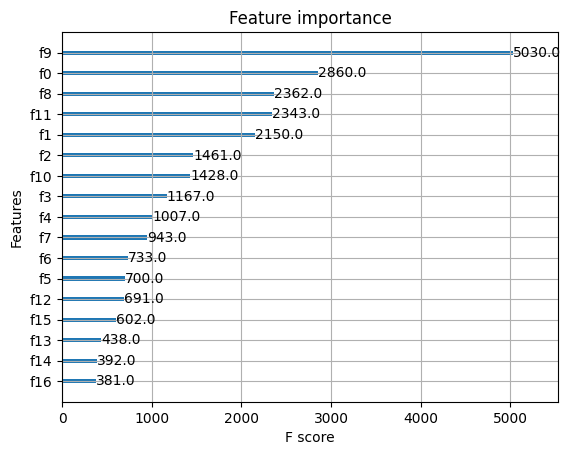

In [24]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_xgb)
plt.show()


In [25]:


# Get the original feature names
original_num_features = X_train.select_dtypes(exclude="object").columns.tolist()
original_cat_features = X_train.select_dtypes(include="object").columns.tolist()

# Get feature names after transformation
onehot_feature_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(original_cat_features).tolist()
all_feature_names = original_num_features + onehot_feature_names  # Combined list

# Create a mapping of f0, f1, ... to actual feature names
feature_importance_dict = {all_feature_names[i]: importance for i, importance in enumerate(best_xgb.feature_importances_)}

# Sort by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importance with actual names
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

O: 0.1674
C: 0.1563
Biomass species_Avocado seed : 0.1076
N: 0.0812
Biomass species_Apricot shell: 0.0786
Biomass species_Baboon seeds : 0.0709
VM: 0.0601
Biomass species_Bagasse: 0.0461
Biomass species_ C. vulgaris: 0.0430
Ash : 0.0352
M: 0.0296
H: 0.0293
FC: 0.0275
PS: 0.0245
HR: 0.0162
FR: 0.0141
FT: 0.0122


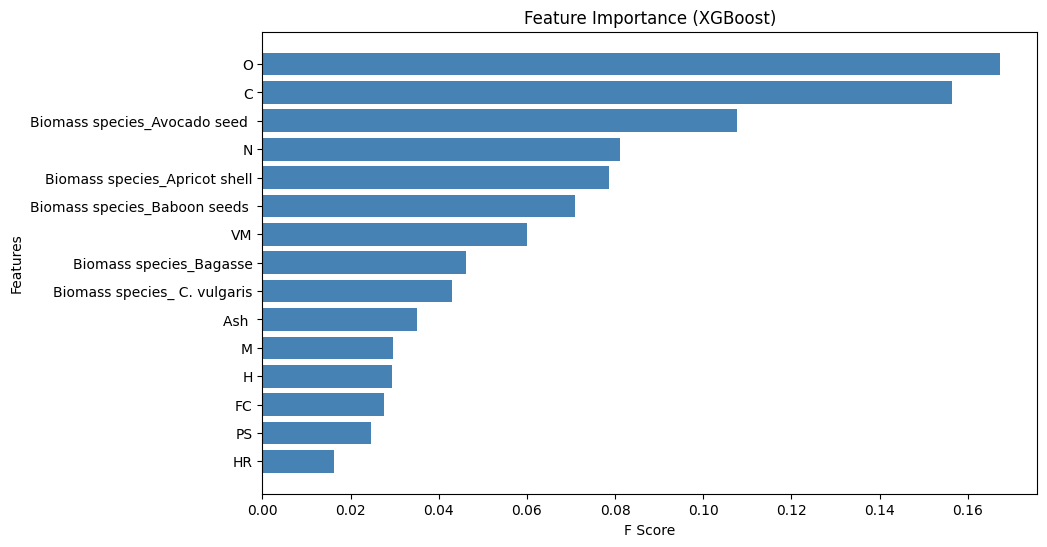

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# Get original feature names
original_num_features = X_train.select_dtypes(exclude="object").columns.tolist()
original_cat_features = X_train.select_dtypes(include="object").columns.tolist()

# Get transformed categorical feature names
onehot_feature_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(original_cat_features).tolist()

# Combine numerical & categorical feature names
all_feature_names = original_num_features + onehot_feature_names

# Get feature importance values
feature_importances = best_xgb.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]  # Descending order
sorted_features = [all_feature_names[i] for i in sorted_indices]
sorted_importance = feature_importances[sorted_indices]

# Plot feature importance with actual names
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:15], sorted_importance[:15], color="steelblue")  # Top 15 features
plt.xlabel("F Score")
plt.ylabel("Features")
plt.title("Feature Importance (XGBoost)")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()



<h3> Correlation Visualisation


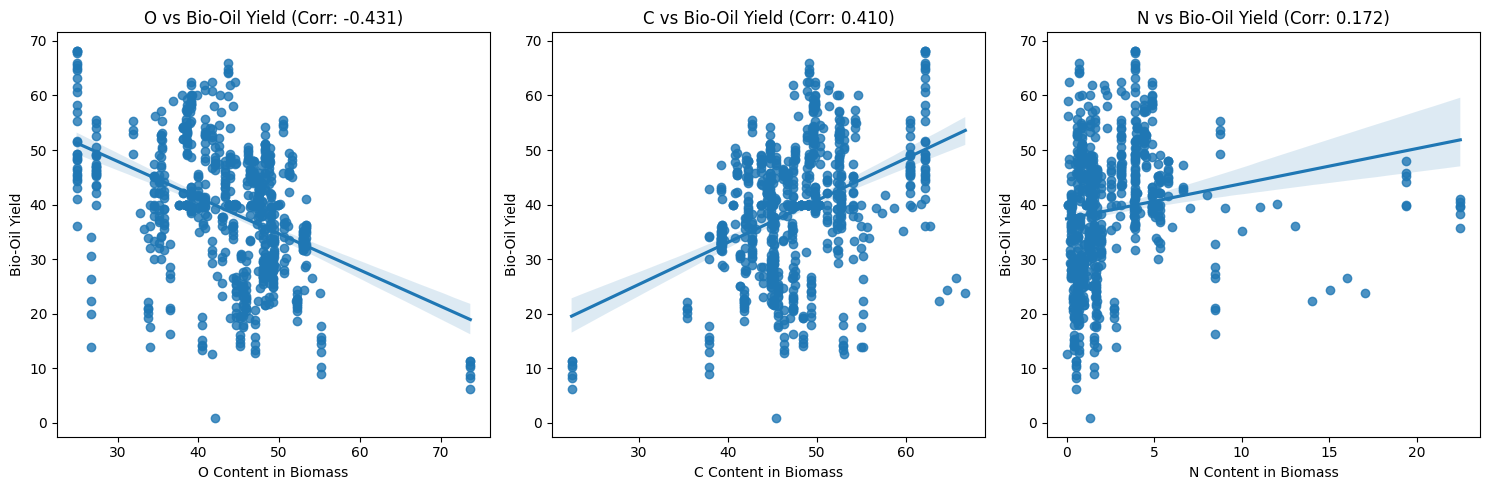

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define features to analyze
features = ["O", "C", "N"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, feature in enumerate(features):
    correlation = df[feature].corr(df["Liquid phase"])  # Compute correlation
    sns.regplot(x=df[feature], y=df["Liquid phase"], ax=axes[i])  # Regression plot
    axes[i].set_xlabel(f"{feature} Content in Biomass")
    axes[i].set_ylabel("Bio-Oil Yield")
    axes[i].set_title(f"{feature} vs Bio-Oil Yield (Corr: {correlation:.3f})")

plt.tight_layout()
plt.show()



<h4>Interpretation of the Data</h4>
<h5>Oxygen (O) vs Bio-Oil Yield (-0.431 Correlation) </h5>

**Negative correlation:** Higher oxygen content in biomass tends to reduce bio-oil yield.<br>
**Possible reason:** Oxygen-rich biomass leads to more water and gas production during pyrolysis, reducing the liquid phase.
<br> <br>
<h5>Carbon (C) vs Bio-Oil Yield (+0.410 Correlation) </h5>

**Positive correlation:** Higher carbon content generally increases bio-oil yield.<br>
**Possible reason:** Carbon is a primary precursor for bio-oil, so biomass with more carbon produces more liquid yield.<br>

<h5>Nitrogen (N) vs Bio-Oil Yield (+0.172 Correlation)</h5>

**Weak positive correlation:** Nitrogen content has a minor effect on bio-oil yield.<br>
**Possible reason:** Nitrogen likely originates from proteins in biomass, which contribute minimally to oil production.